# SHAP Pytorch Deep Explainer MNIST
- SHAP: 
    - https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html
    - https://towardsdatascience.com/shap-how-to-interpret-machine-learning-models-with-python-2323f5af4be9
- LIME: 
    - https://towardsdatascience.com/lime-how-to-interpret-machine-learning-models-with-python-94b0e7e4432e
- SHAP vs LIME: 
    - https://towardsdatascience.com/lime-vs-shap-which-is-better-for-explaining-machine-learning-models-d68d8290bb16
- To do:
    - Apply SHAP
    - Print out model summary
    - Tensorboard Application

In [2]:
!pip3 install torch==1.9.0+cpu torchvision==0.10.0+cpu torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 175.5 MB 34.0 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 14.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 5.2 MB/s eta 0:00:01


## Imports

In [9]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [10]:
BATCH_SIZE = 128
NUM_EPOCHS =2 
DEVICE = torch.device("cpu")

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Initialize convolutional layer
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        # Initialize fully connection layers
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

In [17]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
for epoch in range(1, NUM_EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317272
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.191562
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.730482
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.951213
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.683575

Test set: Average loss: 0.0054, Accuracy: 8763/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.814288
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.773208
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.817203
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.712182
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.435351

Test set: Average loss: 0.0030, Accuracy: 9301/10000 (93%)



## SHAP Analysis on Testing set

In [24]:
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:110] # Get 4 test image 

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [25]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

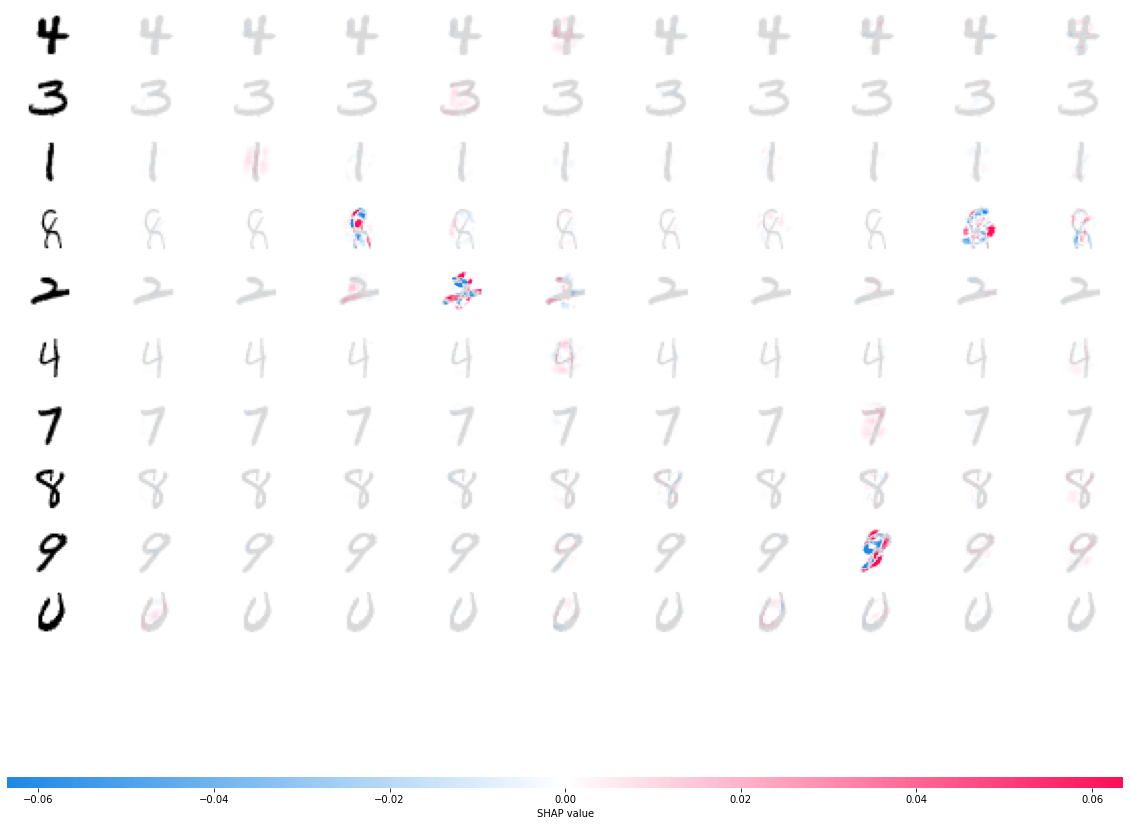

In [26]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)